In [163]:
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

### A) Load Training Data

In [164]:
def load_data(img_folder_path, gt_folder_path):
    '''
    load rgb images and ground truths; 
    calculate the priors for apple pixels and non-apple pixels priors.
    
    Keyword arguments:
    img_folder_path -- path for the rgb training images (.jpg format)
    gt_folder_path -- path for the corressponding ground truths (.png format)
    '''
    imgs = glob.glob(img_folder_path)
    gts = glob.glob(gt_folder_path)
    data_true = []
    data_false = []
    for img, gt in zip(imgs, gts):
        # load images
        image = plt.imread(img)
        image = image / 255 # set the pixel values between [0,1]
        gtruth = (plt.imread(gt)[:,:,0]).astype(int) # ground truth, which only needs 1 channel to construct
        # split the data into apple and non-apple pixels
        for i in range(gtruth.shape[0]):
            for j in range(gtruth.shape[1]):
                if gtruth[i, j] == 1.0:
                    data_true.append(image[i,j])
                else:
                    data_false.append(image[i,j])
    # reshape the data to d x n
    data_true = np.array(data_true).T
    data_false = np.array(data_false).T
    # calculate the priors
    pixels = data_false.shape[1] + data_true.shape[1]
    prior = [data_true.shape[1]/ pixels, data_false.shape[1]/ pixels]
    # print('data_true: {} ; data_false: {}'.format(data_true.shape, data_false.shape))
    return data_true, data_false, prior

### B) Use mixtures of Gaussians to distinguish apple vs. non-apple pixels.

##### Gaussian Probability

In [165]:
def gaussProb(data, mean, cov):
    """
    Returns the gaussian probability of the data
    
    Keyword arguments:
    data: d x n matrix containing data points
    mean: d x 1 vector containing mean parameter of the Gaussian distribution
    cov: d x d matrix covariance parameter of the Gaussian distribution
    """
    nDim = data.shape[0]
    diff = data - mean.reshape(nDim,1)
    brac = (diff.T.dot(np.linalg.inv(cov)) * diff.T).sum(1)
    prob = (np.linalg.det(2 * np.pi * cov)**-0.5) * np.exp(-0.5 * brac)
    return prob

##### Likelihood & Loglikelihood

In [166]:
def likelihood(data, mixGaussEst, log=0):
    """
    Returns the likelihood or log likelihood for the whole data set under a mixture of Gaussian

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    log -- boolean. 1 returns log likelihood, 0 returns likelihood. Default is 0.
    Returns: 
    logLike -- scalar containing the log likelihood.
    """
    nData = data.shape[1]
    like = np.zeros((mixGaussEst['k'], nData))
    for k in range(mixGaussEst['k']):
        update_weight = mixGaussEst['weight'][k]
        update_mean = mixGaussEst['mean'][:, k]
        update_cov = mixGaussEst['cov'][:, :, k]
        like[k, :] = update_weight * gaussProb(data, update_mean, update_cov)
    if log == 0:
        likelihood = np.sum(like, axis=0)
    elif log == 1:
        likelihood = np.sum(np.log(np.sum(like, axis=0)))
    return likelihood

##### EM Algorithm

In [167]:
def fit_gaussian(data, k, nIter):
    '''
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.

    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    nIter -- scalar representing the number of iteration.

    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    '''
    nDim, nData = data.shape

    # initialise values to some random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDim
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDim, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDim, nDim, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDim)

    logLike = likelihood(data, mixGaussEst, log=1)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    postHidden = np.zeros(shape=(k, nData))
    for cIter in range(nIter):
        ### Expectation step ###
        for i in range(k):
            weight = mixGaussEst['weight'][i]
            mean = mixGaussEst['mean'][:,i]
            cov = mixGaussEst['cov'][:,:,i]
            postHidden[i,:] = weight * gaussProb(data, mean, cov)
        postHidden /= np.sum(postHidden, axis=0) + 1e-20 # aviod singularity

        ### Maximization Step ###
        for i in range(k):
            r_ij = postHidden[i,:] # current responsibility
            mixGaussEst['weight'][i] = np.sum(r_ij) / np.sum(postHidden)
            mixGaussEst['mean'][:,i] = (data@postHidden[i,:])/np.sum(r_ij)
            mixGaussEst['cov'][:,:,i] =  ((data - mixGaussEst['mean'][:,i].reshape(nDim,1))*postHidden[i,:]).dot((data - mixGaussEst['mean'][:,i].reshape(nDim,1)).T) / np.sum(r_ij)
        
        # calculate the log likelihood
        logLike = likelihood(data, mixGaussEst, log=1)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter+1, logLike))
    return mixGaussEst

In [168]:
def posterior(im_path, prior, trueEst, falseEst):
    '''
    Returns the posterior of each pixel of a test image of being an apple pixel

    Keyword arguments:
    im_path -- path of the test image.
    prior -- the priors for apple pixels and non-apple pixels priors.
    trueEst -- dict containing the estimated MoG parameters for the apple pixels.
    falseEst -- dict containing the estimated MoG parameters for the non apple pixels.

    '''
    # priors
    prior_true, prior_false = prior
    # set the values of the pixels in range [0,1]
    im = plt.imread(im_path)/255
    imY, imX, imZ = im.shape
    like_true = likelihood(im.reshape(imY*imX,imZ).T, trueEst).reshape(imY,imX)
    like_false = likelihood(im.reshape(imY*imX,imZ).T, falseEst).reshape(imY,imX)
    posterior_true = like_true * prior_true / (like_true * prior_true + like_false * prior_false)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    ax1.imshow(im)
    ax1.set_title('Image')
    ax2.imshow(posterior_true)
    ax2.set_title('Posterior')
    return posterior_true

##### Now we can train the model using the images inside the apple folder

In [170]:
# paths for the training data
imgTrain_path = './apples/*train.jpg'
gtTrain_path = './imgMask/*truth.png'
# load the data
data_true, data_false, prior = load_data(imgTrain_path, gtTrain_path)
data_true, data_false, prior = load_data(imgTrain_path, gtTrain_path)

# train the data: nIter = 50
mixGassEst_true = fit_gaussian(data_true, 3, 50)
mixGassEst_false = fit_gaussian(data_false, 3, 50)

Log Likelihood Iter 0 : -2684925.503

Log Likelihood After Iter 1 : 287799.067

Log Likelihood After Iter 2 : 291208.441

Log Likelihood After Iter 3 : 297572.789

Log Likelihood After Iter 4 : 313710.960

Log Likelihood After Iter 5 : 403145.380

Log Likelihood After Iter 6 : 522455.122

Log Likelihood After Iter 7 : 587934.361

Log Likelihood After Iter 8 : 625266.197

Log Likelihood After Iter 9 : 646819.716

Log Likelihood After Iter 10 : 662608.965

Log Likelihood After Iter 11 : 678107.762

Log Likelihood After Iter 12 : 696000.252

Log Likelihood After Iter 13 : 711885.445

Log Likelihood After Iter 14 : 720053.928

Log Likelihood After Iter 15 : 723793.227

Log Likelihood After Iter 16 : 726170.306

Log Likelihood After Iter 17 : 728140.450

Log Likelihood After Iter 18 : 729961.337

Log Likelihood After Iter 19 : 731656.722

Log Likelihood After Iter 20 : 733199.455

Log Likelihood After Iter 21 : 734571.058

Log Likelihood After Iter 22 : 735764.993

Log Likelihood After Iter

##### C) We can then use the model estimate of the parameters to calculate the posterior properbility on the test images.

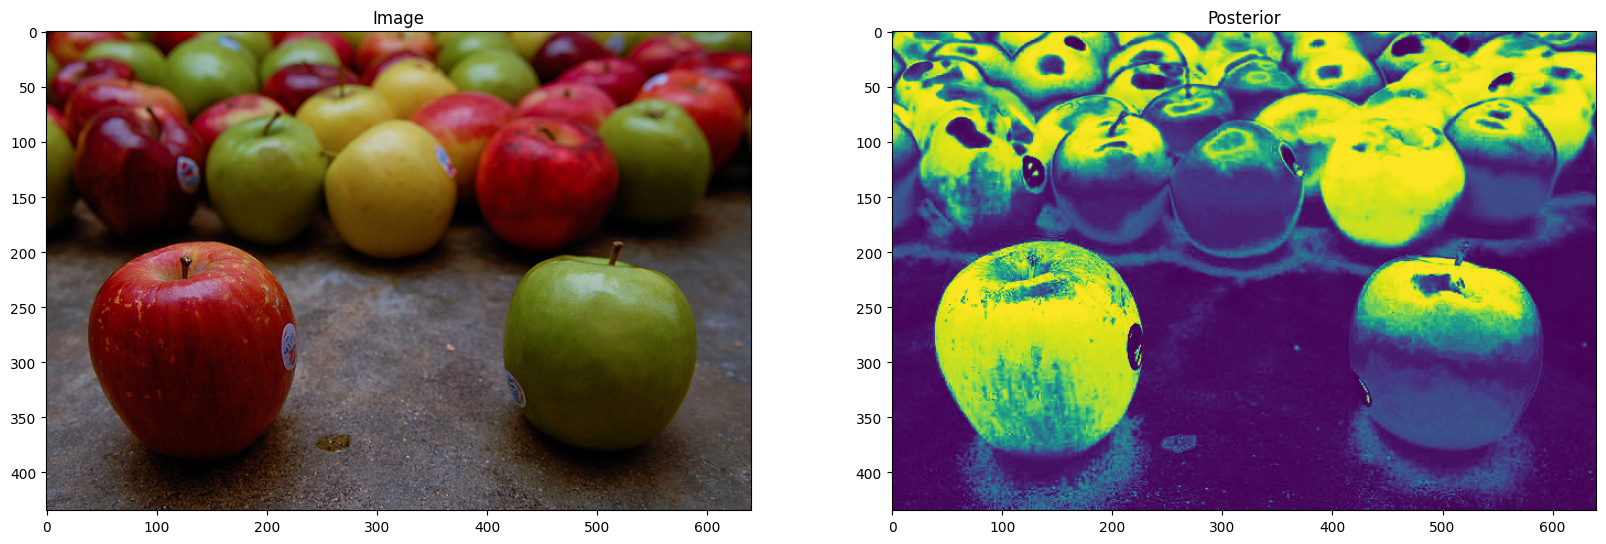

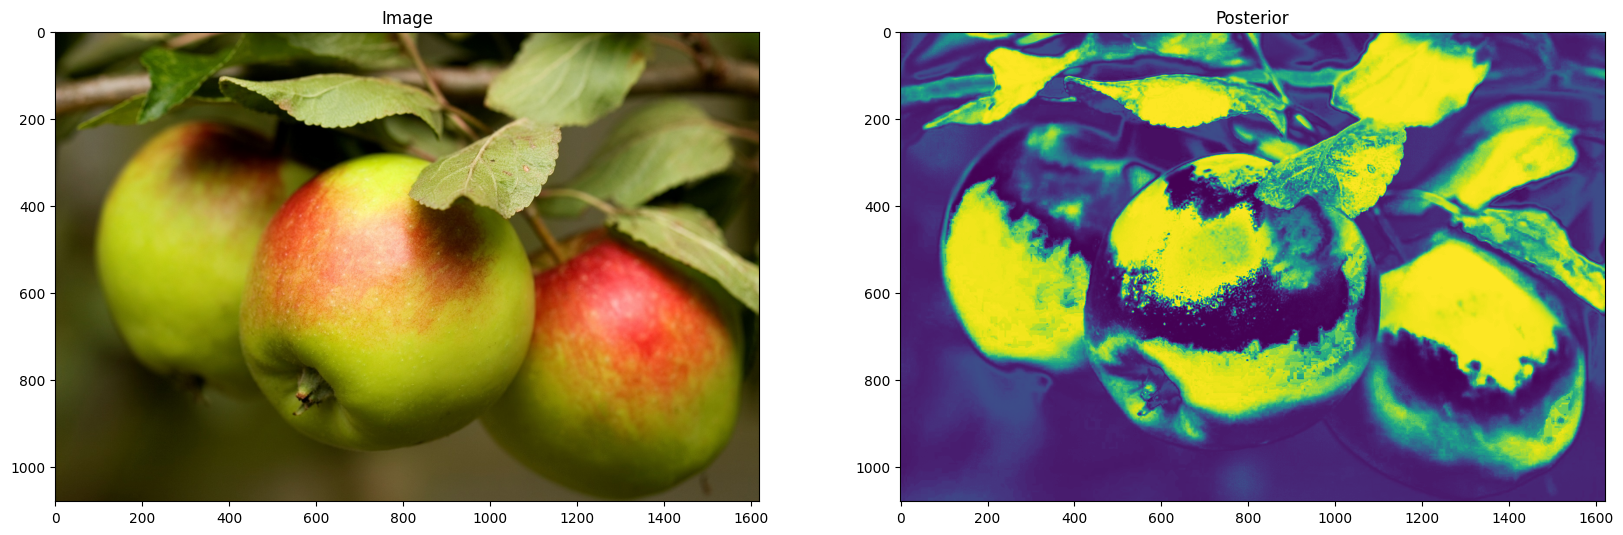

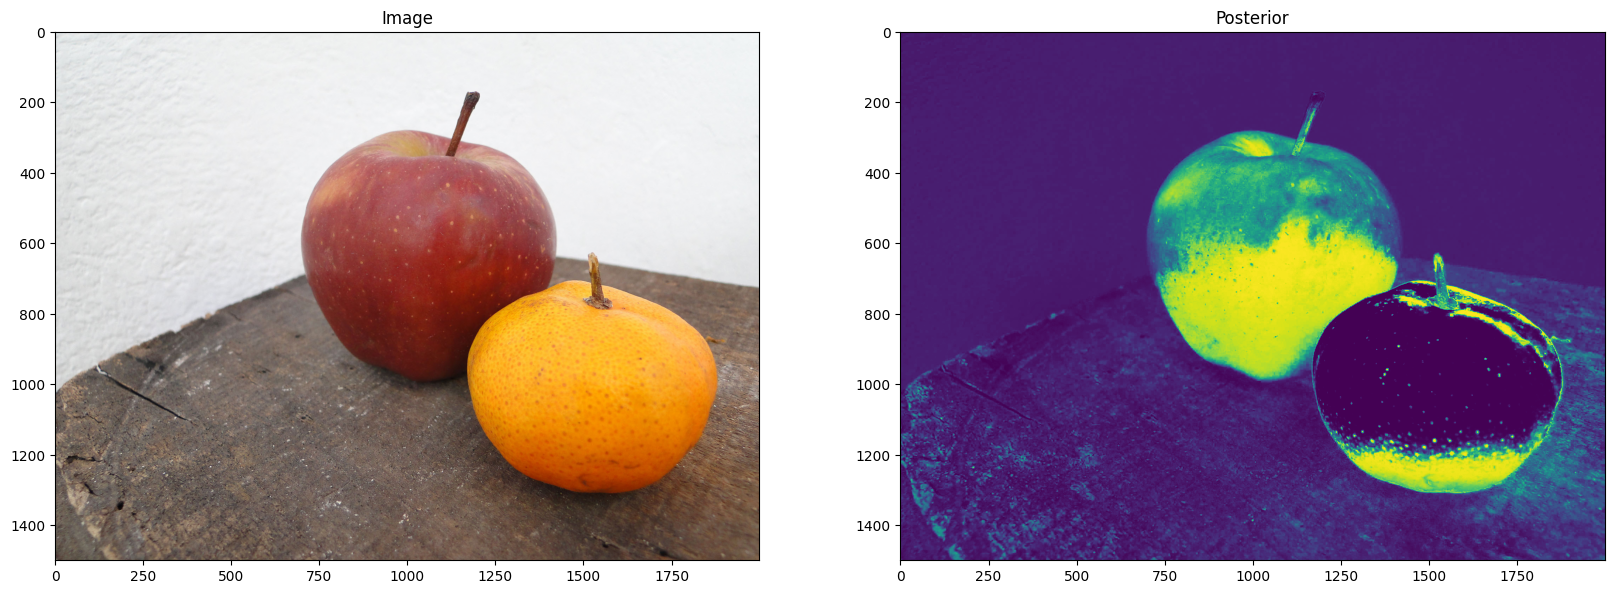

In [171]:
p1 = posterior('./apples/im4test.jpg', prior, mixGassEst_true, mixGassEst_false)
p2 = posterior('./apples/im5test.jpg', prior, mixGassEst_true, mixGassEst_false)
p3 = posterior('./apples/im6test.jpg', prior, mixGassEst_true, mixGassEst_false)

Top figure: The classifier performs reasonably when the image is composed of mainly green apples and apples. \
Middle figure: The classifier performs decently when the image background (and non-apple pixels) are predominately not red/green. \
Bottom figure: The classifier performs poorly when the non-apple pixels are similiar in color to the apple pixels. \
The results are expected because:
1) our training samples is too small.
2) we have a validation set to fine tune the hyperparameters k, the number of gaussians.
3) if the target and non-target pixels are similiar then the posterior probability for the latter will also being higher.

##### D) ROC Curve
We use the ROC score to quantity our model performance.

In [172]:
def posterior_bin(posterior, threshold = 0.5):
    '''
    Returns the posterior binary of a given threshold.

    Key arguments:
    posterior -- the probability of each pixel being an apple pixel
    threshold -- a value for which if the posterior is greater than this, the pixel is labeled as true. (i.e. it is an apple pixel)
    '''
    return (posterior > threshold).astype(int)


In [173]:
def roc_score(posterior, threshold, true_bin):
    '''
    Returns the roc score, sensitivity, and specificity of the results on a test image.

    Key arguments:
    posterior -- the probability of each pixel being an apple pixel
    threshold -- a value for which if the posterior is greater than this, the pixel is labeled as true. (i.e. it is an apple pixel)
    true_bin -- the binary mask for apple pixels
    '''
    post_bin = (posterior > threshold).astype(int)

    # we want to distinguish true positive and false positive,
    # we multipy post_bin by 2 so the differences for
    d = 2 * post_bin - true_bin
    true_p = np.sum(d == 1)
    true_n = np.sum(d == 0)
    false_p = np.sum(d == 2)
    false_n = np.sum(d == -1)

    # Calculate required metrics for F1 and ROC
    sensitivity = true_p / (true_p + false_n + 1e-20)
    specificity = true_n / (true_n + false_p + 1e-20)

    roc = sensitivity * specificity

    return roc, sensitivity, specificity
    


In [174]:
def plot_roc(posterior, true_bin_path):
    """
    Plots ROC curve provided that the image has a ground truth.

    Key Arguments:
    posterior -- the probability of each pixel being an apple pixel
    true_bin_path -- path of the ground truth image
    """
    # true_bin = (plt.imread(true_bin_path)[:,:,0])
    image = cv2.imread(true_bin_path)
    true_bin = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) /255
    rocs = []
    sensitivity = []
    specificity = []
    for i in range(1,100):
        th = i/100 # we want to plot the threshold from 0.01 to 0.99
        roc, sens, spec = roc_score(posterior, th, true_bin)
        rocs.append(roc)
        sensitivity.append(sens)
        specificity.append(spec)
    best_th = rocs.index(max(rocs)) / 100
    fpr = 1 - np.array(specificity)
    plt.plot(fpr, sensitivity)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    # plot the best threshold point
    _, s1, s2 = roc_score(posterior, best_th, true_bin)
    plt.plot(1-s2, s1, 'ro-', label=f'Best threshold {best_th}')
    plt.legend()
    return best_th

Let's plot the ROC curve for the second test image (p2) which has a ground truth.

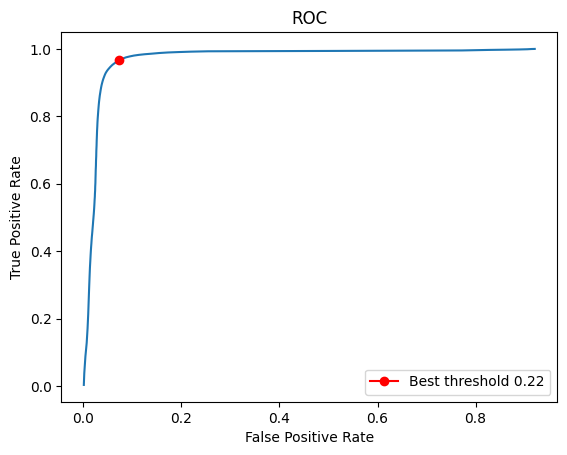

In [177]:
best_threhold = plot_roc(p3, './imgMask/im6truth.png')

Figure: we can see that the best threshold is almost right on the turning point of the curve. The value is considered to be the best because it corresponds to the high true positive rate without comprimising the false positiva rate.

##### E) My Apple Images
Download 2 non-copyrighted apple images for testing.

In [178]:
import matplotlib.cm as cm
import cv2
def to_gt(img_path):
    '''
    Helper function -- saves the ground truth as a binary image

    Key argument:
    img_path -- the path for the coloured ground truth image.

    (it is not called in this notebook. However it is still useful
     to know how to turn an image to black and white.)
    
    '''
    data = plt.imread((img_path))[:,:,0]
    data = (data == 1.0).astype(int)
    print(data.shape)
    plt.imsave('myapple3_bin.png', np.array(data), cmap=cm.gray)


Display the results!

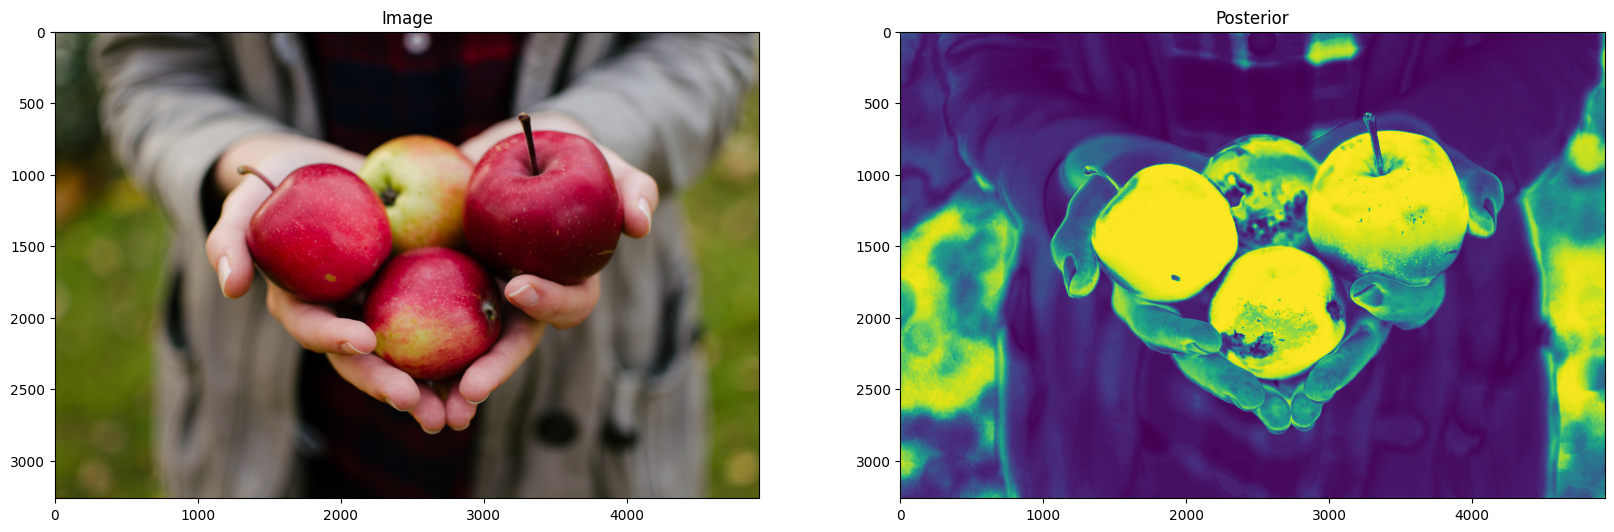

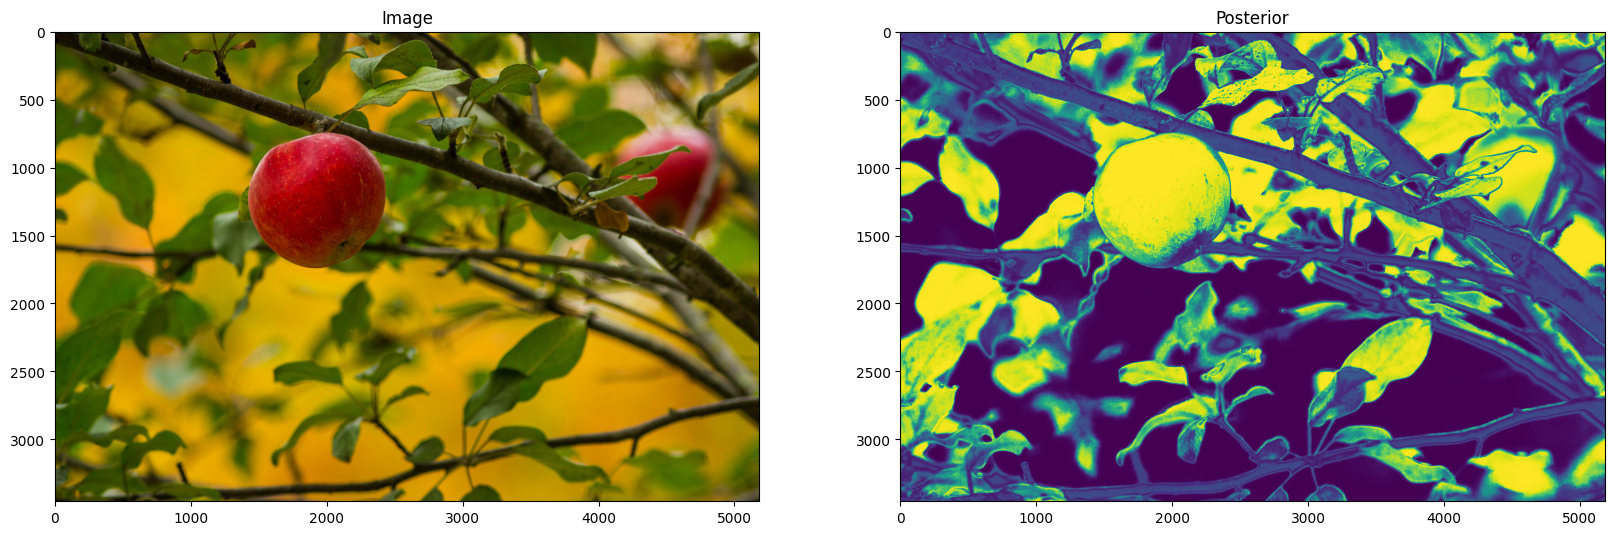

In [180]:
myapple1_post = posterior('./apples/myapple1.jpg', prior, mixGassEst_true, mixGassEst_false)
myapple2_post = posterior('./apples/myapple2.jpg', prior, mixGassEst_true, mixGassEst_false)

Both figures: As expected, accuracy on images with similar colours is very low. The colour of the grass and the leafs matches that of green apples in our training set, thus they are assigned a high proterior probability.

Text(0.5, 1.0, 'Ground Truth')

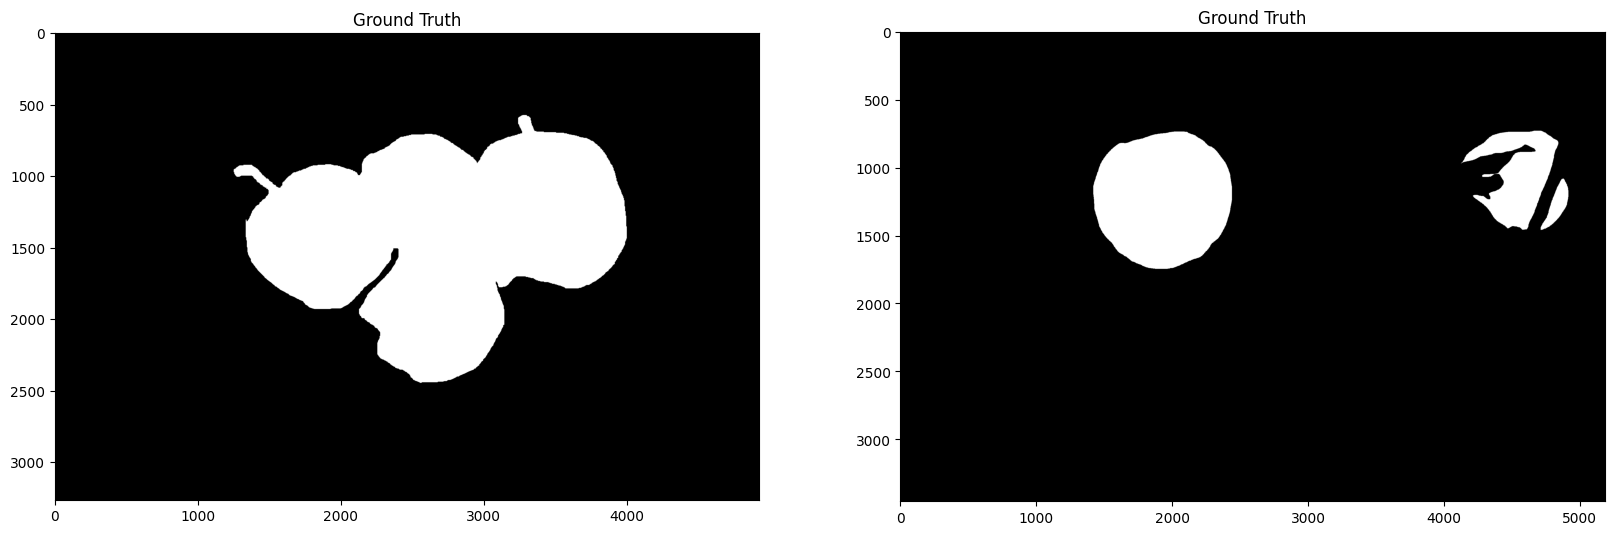

In [192]:
myapple1_bin = cv2.imread('./imgMask/myapple1_bin.png')
myapple2_bin = cv2.imread('./imgMask/myapple2_bin.png')
_, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 20))
ax1.imshow(myapple1_bin)
ax2.imshow(myapple2_bin)
ax1.set_title('Ground Truth')
ax2.set_title('Ground Truth')

Figures: the ground truths for the above images for comparison.

Below, we quantify the results using the ROC curves.

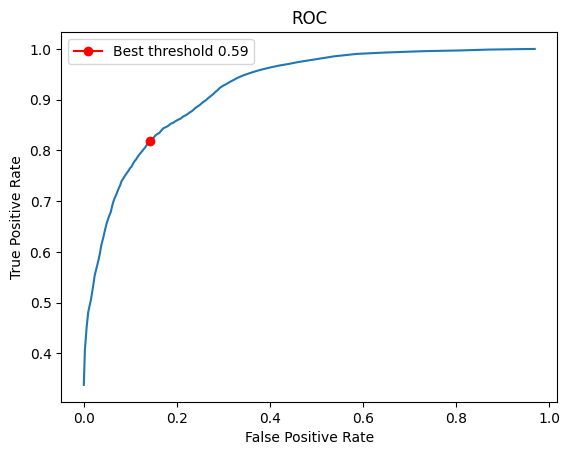

In [184]:
myapple1_th = plot_roc(myapple1_post, './imgMask/myapple1_bin.png')

Figure: (myapple1.jpg) the best we can do for this image is to set the threshold to 0.59 to get a ~80% true positive rate with 20% false positive rate.

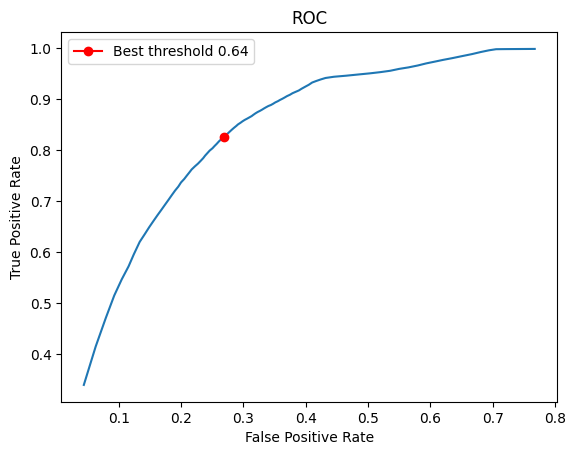

In [194]:
myapple2_th = plot_roc(myapple2_post, './imgMask/myapple2_bin.png')

Figure: (myapple2.jpg) the gradient of the curve changes gradually instead of abruptly. This is a sign that our model performed poorly as there is a huge price to pay if we want to increase the true positive rate.

### F) We should really be using three separate sets of files: a training set, a validation set, and test set! Explain why.

Validation set is used for tuning the hyperparameter values. In our case, the values are the number of gaussians (k) we would to fit the data, and the threshold for classifying the posterior probability of each pixel as apple/non-apple pixel (that is, if the probability is greater than the threshold the pixel is labeled as apple pixel.) \
Once a choice of hyperparmeter values are decided, we then proceed to train the model using the training set to achieve the optimum estimated model parameters. \
Lastly, we apply our estimated parameters to a test set to evalute the model accuracy for unseen data.
